# Libraries and Requirements

In [3]:
library(tidymodels)
library(tidyverse) # for tidy syntax
library(janitor) # for handling column names
library(data.table) # for fast processing of data
library (skimr) # to get a fast grasp of the dataset
library(broom)
library(tidytext)
library(patchwork)
library(corrplot)
library(caret)
library(mice) # for imputing missing values
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("DESeq2")
# library("DESeq2")
print(0)

── Attaching packages ────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.7      ✔ recipes      0.1.16
✔ dials        0.0.9      ✔ rsample      0.1.0 
✔ dplyr        1.0.7      ✔ tibble       3.1.2 
✔ ggplot2      3.3.4      ✔ tidyr        1.1.3 
✔ infer        0.5.4      ✔ tune         0.1.5 
✔ modeldata    0.1.0      ✔ workflows    0.2.2 
✔ parsnip      0.1.5      ✔ workflowsets 0.0.2 
✔ purrr        0.3.4      ✔ yardstick    0.0.8 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   1.4.0     ✔ forcats 0.5.1
✔ stringr 1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_f

[1] 0


# Load the data files

In [4]:
keys <- as.data.table(read_csv("../input/input-data/crypto_wake_up_sample_sheet.csv")) %>% clean_names()
genes <- as.data.table(read_csv("../input/input-data/H99_all_genes_promoter_500nt_4mer_counts.csv", skip = 10, col_names = FALSE) %>%
      row_to_names(row_number = 1)) %>% clean_names() %>% mutate_at(vars(-gene), as.numeric)
experiment <- as.data.table(read_csv("../input/input-data/CW_kallisto_abundance_fold_change_long_by_gene.csv")) %>% clean_names()


── Column specification ────────────────────────────────────────────────────────
cols(
  sample_ID = col_character(),
  code = col_character(),
  medium = col_character(),
  temp = col_character(),
  time = col_double(),
  rep = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  code = col_character(),
  gene = col_character(),
  est_counts = col_double(),
  TPM = col_double(),
  fold_change = col_double()
)




# Missing Data Handling

In [5]:
handle.missing.data <- function(df) {
    
  df <- df %>%
    mutate(fold_change = case_when(est_counts + tpm == 0 ~ 0,
                                   TRUE ~ fold_change)) %>% 
    mutate(fold_change = na_if(fold_change, Inf)) # Convert Infities to NA to impute them with mice
    
    # ----------------------------- Imputing Missing Values ---------------------------------------------------
    # https://stackoverflow.com/questions/52713733/how-to-use-predict-function-with-my-pooled-results-from-mice
    df %>% select(est_counts, tpm, fold_change) %>% md.pattern()

    stripplot <- df %>%
      select(est_counts, tpm, fold_change) %>%
      mice(printFlag=FALSE, seed=1903, m=5, method="pmm") %>%
      stripplot()

    imps <- df %>% select(est_counts, tpm, fold_change) %>% mice(printFlag=FALSE, seed=1903, m=5, method="pmm") # imputing missing values
    fit <-  imps %>% with(exp=lm(fold_change ~ est_counts + tpm)) # setting the expression
    pooled <- fit %>% pool() # pooling the models. 
    print(pool.r.squared(fit, adjusted = TRUE)) # printing the adjusted R-square as a measure to choose the best model for imputing missing data
    
    
    pooled_lm = fit$analyses[[1]]
    pooled_lm$coefficients = summary(pooled)$estimate # pooling the predicted coefficients of the models.
    prediction <- predict(pooled_lm, newdata = experiment) %>% as.data.frame() # predicting with those coefficients 

    df <- cbind(df, prediction) %>% 
    rename(prediction = ".") %>%
    mutate(fold_change = case_when(is.na(fold_change) ~ prediction, 
                                   TRUE ~ fold_change)) %>% 
    select(-prediction)   
  return(list(df, stripplot))
}

                 est        lo 95       hi 95 fmi
adj R^2 0.0001640572 8.385301e-05 0.000270915 NaN


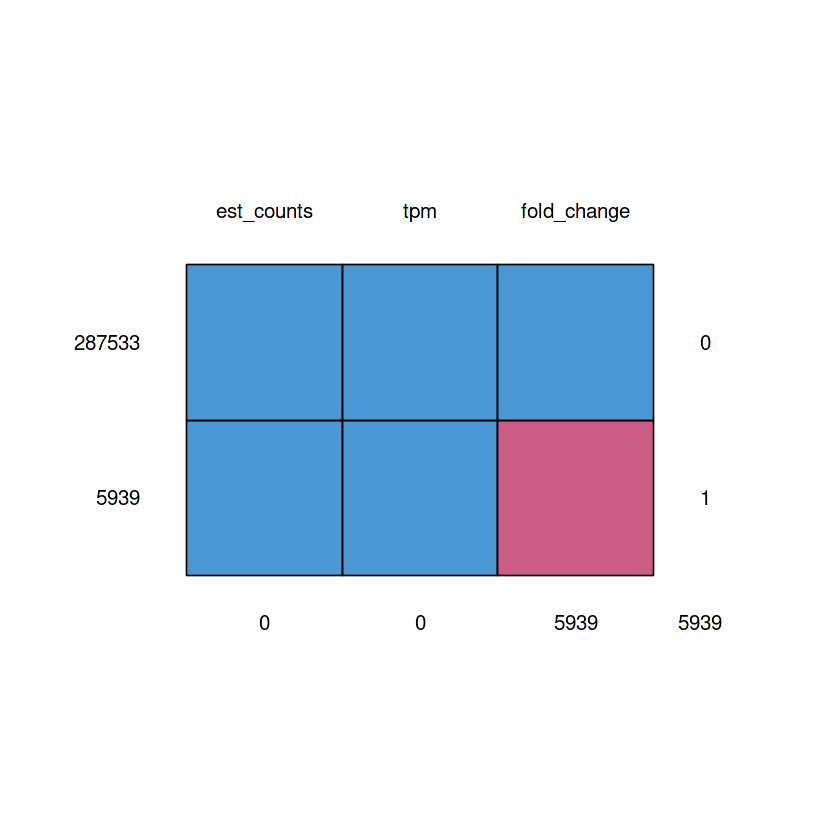

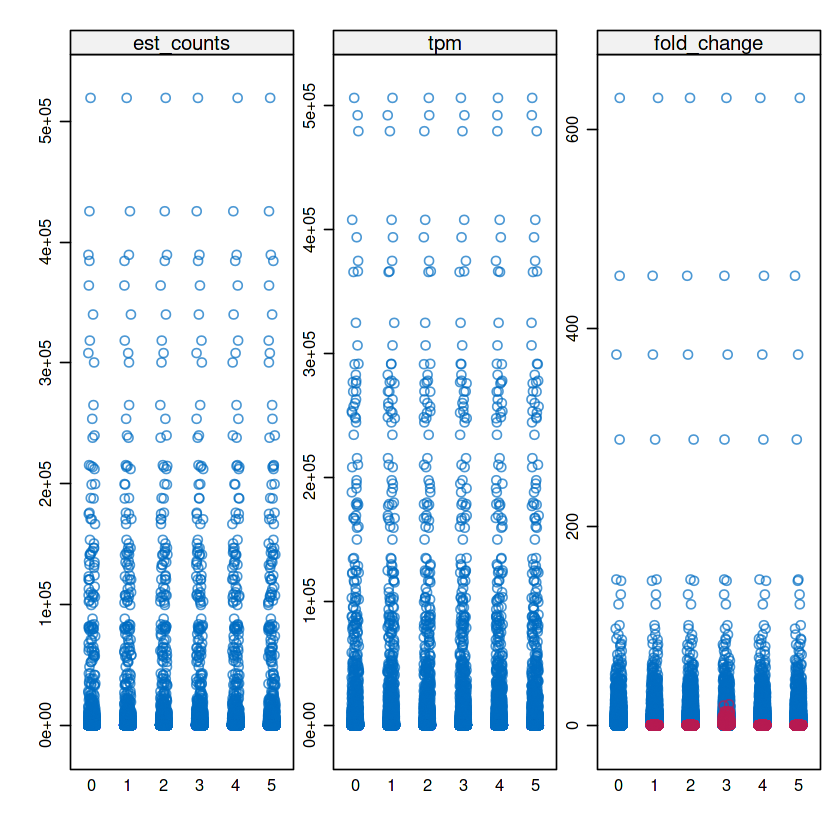

In [6]:
missing.data.results <- experiment %>% handle.missing.data()
stripplot <- missing.data.results[2][[1]]
stripplot
experiment <- missing.data.results[1][[1]]

In [ ]:
keys %>% head() 
genes %>% head() 
experiment %>% head() 

# Joining Datasets

In [ ]:
exp <- experiment %>% 
  left_join(keys, by = "code") %>%
  select(gene, medium, temp, time, rep, est_counts, tpm, fold_change)
skim(exp)

df <- exp %>%
  left_join(genes, by = "gene") %>%
  mutate(row_name = paste(gene, medium, temp, time, rep, sep="-"), .before=gene) %>%
  remove_rownames %>%
  column_to_rownames("row_name") %>% as.data.frame()
df %>% head()

In [ ]:
dmy <- dummyVars("~ medium + temp + time + rep ", data = df)
df.model <- data.frame(predict(dmy, newdata = df))
df.model <- cbind(df.model, df) %>%
  select(-medium, -temp, -time, -rep, -gene) %>% 
  clean_names() %>% 
  relocate(c(est_counts, tpm, fold_change), .before=medium_rpmi)

df.model %>% head() 

# Univariate Analysis

In [ ]:
plot.univariate <- function(var, density, dat = df) {
  color = "blue4"
  density = TRUE
  if (var == "est_counts") {
    density = FALSE
  }
  
    
  
  if (density) {
    gg.var <- dat %>% select(1:8) %>% ggplot(aes(x = .data[[var]])) +
      geom_density(col = color,
                   fill = color,
                   alpha = 0.8) +
      theme(axis.title.x = element_blank(),
            axis.title.y = element_blank()) +
      ggtitle(var) +
      xlim(0, 10 + 90 * (var != "fold_change")) +
      theme_minimal()
  } else {
    gg.var <- ggplot(data = dat, aes(x = .data[[var]])) +
      geom_histogram(
        col = color,
        fill = color,
        alpha = 0.7,
        bins = 30
      ) +
      theme(axis.title.x = element_blank(),
            axis.title.y = element_blank()) +
      ggtitle(var) +
      xlim(0, 10 + 90 * (var != "fold_change")) +
      theme_minimal()
  }
  return(gg.var)
}

In [ ]:
names <- c("est_counts", "tpm", "fold_change")
names <- set_names(names)
plots <- map(names, ~ plot.univariate(.x))
plots[[1]] + plots[[2]] + plots[[3]]

In [ ]:
df %>% select(gene, medium, temp, time, rep, fold_change) %>%
  ggplot(aes(x = fold_change, col = medium, fill = medium), show.legend = FALSE) +
  geom_density(alpha = 0.8) +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_blank()) +
  ggtitle("Fold Change Density") +
  facet_grid(medium ~ .) +
  xlim(0, 10) +
  theme_minimal() +
  theme(legend.position = "none")

# PCA on full data
## Centering the data matrix

In [ ]:
df.exp <- df.model
df.sample <- df.exp %>% sample_n(size=nrow(df.exp)/3, replace=FALSE) %>% filter(fold_change<5)

df.X <- df.sample %>% select(-est_counts, -tpm, -fold_change)
df.y <- df.sample %>% select(fold_change)

df.cntr.X <- select_if(df.X, is.numeric) %>% 
  scale(center = TRUE, scale = TRUE) %>% 
  as.data.table()
df.cntr.X %>% head() 

svd.results <- svd(df.cntr.X)

## Variance explained by PC

In [ ]:
# interpret variance explained 
svd.var.exp <- tidy(svd.results, matrix = "d")

svd.var.exp %>% ggplot(aes(x = PC, cumulative)) +
  geom_line() +
  # scale_x_continuous(breaks = seq(min(svd.var.exp$PC),max(svd.var.exp$PC),by=1)) +
  # coord_cartesian(xlim = c(1, 200)) +
  labs(title = "Variance Explained by PCs") +
  theme_minimal()

## Column wise interpretation of PCA loadings

In [ ]:
# interpret loadings - working on columns
svd.loadings <- tidy(svd.results, matrix="v") %>%
                mutate(element = colnames(df.cntr.X)[column])

svd.loadings %>% filter(PC<=4) %>%
  group_by(PC) %>%
  top_n(10, abs(value)) %>%
  ungroup() %>%
  mutate(element = reorder_within(element, value, PC)) %>%
  ggplot(aes(x=element, y=value, fill=factor(PC))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~PC, scales="free") +
  scale_x_reordered() + 
  coord_flip() +
  labs(title = "First four PCs of feautures") + 
  theme_minimal()

## Row wise interpretation of PCA loadings

In [ ]:
# interpret loadings - working on rows
svd.loadings.row <- tidy(svd.results, matrix="u") %>%
                mutate(gene_names = rownames(df.X)[row])

svd.loadings.row %>% filter(PC<=4) %>%
  group_by(PC) %>%
  top_n(10, abs(value)) %>%
  ungroup() %>%
  mutate(gene_names = reorder_within(gene_names, value, PC)) %>%
  ggplot(aes(x=gene_names, y=value, fill=factor(PC))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~PC, scales="free") +
  scale_x_reordered() + 
  coord_flip() +
  labs(title = "First four PCs of feautures") + 
  theme_minimal()

## PCA Biplot

In [ ]:
# final plot
svd.pcs <- tidy(svd.results, matrix = "u")

svd.pcs.1 <- svd.pcs %>% filter(PC == 1) %>%
  mutate(PC1 = value) %>%
  select(PC1)
svd.pcs.2 <- svd.pcs %>% filter(PC == 2) %>%
  mutate(PC2 = value) %>%
  select(PC2)
svd.pcs.3 <- svd.pcs %>% filter(PC == 3) %>%
  mutate(PC3 = value) %>%
  select(PC3)
df.pcs <- cbind(df.y, svd.pcs.1, svd.pcs.2, svd.pcs.3)

df.pcs %>%
  ggplot(aes(
    x = PC1,
    y = PC2,
    col = fold_change,
    fill = fold_change
  )) +
  geom_jitter(shape = 21, col = "black") +
  labs(title = "PC1 vs PC2", fill = "fold_change") +
  theme_minimal()

# PCA on experiment data
## Centeing the data matrix

In [ ]:
df.exp <- df.model 
df.sample <- df.exp %>% sample_n(size=nrow(df.exp)/2, replace=FALSE) %>% filter(fold_change<5) %>% select(1:10)

df.X <- df.sample %>% select(-est_counts, -tpm, -fold_change)
df.y <- df.sample %>% select(fold_change)

df.cntr.X <- select_if(df.X, is.numeric) %>% 
  scale(center = TRUE, scale = TRUE) %>% 
  as.data.table()
df.cntr.X %>% head() 

svd.results <- svd(df.cntr.X)

## Variance explained by PC scores

In [ ]:
# interpret variance explained 
svd.var.exp <- tidy(svd.results, matrix = "d")

svd.var.exp %>% ggplot(aes(x = PC, cumulative)) +
  geom_line() +
  # scale_x_continuous(breaks = seq(min(svd.var.exp$PC),max(svd.var.exp$PC),by=1)) +
  # coord_cartesian(xlim = c(1, 200)) +
  labs(title = "Variance Explained by PCs") +
  theme_minimal()

## Column wise interpretation of PCA loadings

In [ ]:
# interpret loadings - working on columns
svd.loadings <- tidy(svd.results, matrix="v") %>%
                mutate(element = colnames(df.cntr.X)[column])

svd.loadings %>% filter(PC<=4) %>%
  group_by(PC) %>%
  top_n(10, abs(value)) %>%
  ungroup() %>%
  mutate(element = reorder_within(element, value, PC)) %>%
  ggplot(aes(x=element, y=value, fill=factor(PC))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~PC, scales="free") +
  scale_x_reordered() + 
  coord_flip() +
  labs(title = "First four PCs of feautures") + 
  theme_minimal()

# Bivariate Analysis

In [ ]:
df <- df %>% as.data.table()
numcols <- sapply(df, is.numeric)
df.corr <- df[, ..numcols] %>% cor(use="pairwise.complete")

df.corr.big <- df.corr*(abs(df.corr)>0.6)
df.corr.big <- df.corr.big[-which(abs(rowSums(df.corr.big))==1),-which(abs(colSums(df.corr.big))==1)]

square.cor <- corrplot(df.corr.big,
                       order="hclust",
                       addrect=14,
                       method='square',
                       diag=FALSE,
                       tl.col="black",
                       tl.cex = 0.9,
                       outline=TRUE,
                       cl.lim=c(-1, 1),
                       mar=c(0,0,1.5,0))

# Question 1

Find genes that have different expression across design conditions.

In [ ]:
df.full <- df %>%
  select(gene, medium, temp, time, rep, fold_change) %>%
  filter(rep=="A") %>% 
  select(-rep) %>% 
  group_by(gene, medium, temp) %>%
  filter(time %in% c(10, 120)) %>%
  ungroup()

df10 <- df.full %>% filter(time==10)
df120 <- df.full %>% filter(time==120)

df.format <- df10 %>%
  left_join(df120, by=c("gene", "medium", "temp")) %>%
  mutate(fold_change.10=fold_change.x, .before=fold_change.x) %>%
  mutate(fold_change.120=fold_change.y, .before=fold_change.y) %>%
  select(-time.y, -time.x, -fold_change.x, -fold_change.y) 

extreme.cases <- df.format %>% 
  group_by(gene, medium, temp) %>% 
  mutate(fold_change_diff = fold_change.120 - fold_change.10) %>% 
  arrange(-fold_change_diff) %>% 
  ungroup() %>%
  filter(row_number() > max(row_number()) - 5 | row_number() <= 5)

cases <- extreme.cases %>% select(gene) %>% as.matrix()

In [ ]:
piazza <- c("CNAG_00121", "CNAG_06917")
pca.example <- c("CNAG_01842", "CNAG_03788")

big <- exp %>%
  filter(gene %in% cases[1:5], rep == "A", temp != "30C") %>%
  select(-est_counts, -tpm, -rep) %>%
  ggplot(aes(x = time, y = fold_change, col=gene)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  theme(legend.position = "none") +
  labs(title="Most overall change over time") +
  facet_wrap( ~ medium + temp, scale="free") 

small <- exp %>%
  filter(gene %in% cases[6:10], rep == "A", temp != "30C") %>%
  select(-est_counts, -tpm, -rep) %>%
  ggplot(aes(x = time, y = fold_change, col=gene)) +
  geom_line() +
  geom_point() + 
  theme_minimal() +
  theme(legend.position = "none",
        axis.title.y=element_blank()) +
  labs(title="Least overall change over time",
       caption=paste("Most: ", paste(cases[1:5], collapse = ', '), "\n",
                     "Least: ", paste(cases[6:10], collapse = ', '))) +
  facet_wrap( ~ medium + temp, scale="free") 

big + small

In [ ]:
x <- exp %>%
select(-est_counts, -tpm) %>%
filter(temp=="25C", time==10, rep=="A") %>% 
mutate(log_fold_change = log2(fold_change+1)) %>%
select(gene, medium, log_fold_change) %>% 
mutate(t.value = qt(0.975,2)) %>%
group_by(medium) %>%
mutate(mean = median(log_fold_change), 
       stdev = sd(log_fold_change)) %>%
ungroup() %>%
mutate(t.test = ((log_fold_change - mean)*(sqrt(2)))/stdev,
       pass = t.test > t.value) 

x %>% filter(pass)

# library(rstatix)

# xx <- exp %>%
# select(-est_counts, -tpm) %>%
# filter(temp=="25C", time==10, rep=="A") %>% 
# mutate(log_fold_change = log2(fold_change+1)) %>%
# select(gene, medium, log_fold_change)

# xx %>% 
# group_by(gene) %>%
# t_test(data=., log_fold_change ~ medium)

# Question 2

Find motifs that are associated with genes that have different expression across design conditions (and are not associated with the ones that are not differentially expressed).

Investigate whether a (relatively) small set of motifs can predict the observed patterns of gene expression.

Firstly we need to fix the systematic bias in the data that exists between the replicates.

In [ ]:
# fixing the systemic bias.
y1 <- df.model %>% select(fold_change, rep_a) %>% filter(rep_a == 1) %>% mutate(log_fc = log(fold_change+1,2)) %>% select(log_fc) %>% as.matrix()
y2 <- df.model %>% select(fold_change, rep_b) %>% filter(rep_b == 1) %>% mutate(log_fc = log(fold_change+1,2)) %>% select(log_fc) %>% as.matrix()
ss = smooth.spline(y2, y1-y2, lambda=0.01)
plot(y2,y1-y2)
lines(ss, col=2)
abline(h=0, col=4,lwd=2)

bias = rep(NA, length(y2)) 
for(i in 1:length(y2)){
    bias[i] <- as.numeric(predict(ss, x=y2[i])$y)
}
y1.new = y1-bias
y2.new = y2

In [ ]:
# Rebuilding the dataset according to the smooth splines output. 
df.model <- cbind(df.model, y1, y2) %>%
rename(log_fc_a = "log_fc") %>% 
rename(log_fc_b = "log_fc") %>%
mutate(log_fc_a = log_fc_a * rep_a, 
       log_fc_b = log_fc_b * rep_b, 
       log_fc = log_fc_a + log_fc_b,
       fold_change = 2**log_fc - 1) %>% 
select(-log_fc_a, -log_fc_b, -log_fc)
# df.model %>% head()
df.model.copy <- df.model %>% select(-tpm, -est_counts, -medium_rpmi, -medium_ypd, -temp25c, -temp30c, -temp37c, -rep_a, -rep_b) 
df.model.copy %>% head()

## Build the models

### Dataset split

In [ ]:
set.seed(1903)
split <- initial_split(df.model.copy, prop=.8, strata=fold_change)
train_data <- training(split)
test_data <- testing(split)

In [ ]:
data_recipe <- recipe(fold_change ~ ., data = train_data) %>%
  step_zv(all_numeric(), -all_outcomes()) %>%
  step_normalize(all_numeric(), -all_outcomes())

data_prep <- data_recipe %>%
  prep(strings_as_factors=FALSE)

lasso_spec <- linear_reg(penalty=0.1, mixture=1) %>% set_engine("glmnet")

wf <- workflow() %>% add_recipe(data_recipe)
lasso_fit <- wf %>% add_model(lasso_spec) %>% fit(data=train_data)

lasso_fit %>%
  pull_workflow_fit() %>%
  tidy()

In [ ]:
# Tune lasso
data_boot <- bootstraps(train_data, strata=fold_change)

tune_spec <- linear_reg(penalty=tune(), mixture=1) %>% 
    set_engine('glmnet')

lambda_grid <- grid_regular(penalty(),
                            levels=50)

lasso_grid <- tune_grid(wf %>% add_model(tune_spec),
          resamples = data_boot,
          grid = lambda_grid)

In [ ]:
lasso_grid %>%
  collect_metrics()

In [ ]:
lasso_grid %>%
  collect_metrics() %>%
  ggplot(aes(penalty, mean, color = .metric)) +
  geom_errorbar(aes(
    ymin = mean - std_err,
    ymax = mean + std_err
  ),
  alpha = 0.5
  ) +
  geom_line(size = 1.5) +
  facet_wrap(~.metric, scales = "free", nrow = 2) +
  scale_x_log10() +
  theme(legend.position = "none")

In [ ]:
# fit.cv.lasso <- cv.glmnet(as.matrix(X.train), as.matrix(y.train),
#                           family='binomial', type.measure = c('auc'))
# fit.cv.ridge <- cv.glmnet(as.matrix(X.train), as.matrix(y.train),
#                           family='binomial', type.measure = c('auc'), alpha=0)

Forward and Backward models

In [ ]:
# full.model <- glm(fold_change ~ ., data=train_data, family=gaussian(link=log))
# null.model <- glm(fold_change ~ 1, data=train_data, family=gaussian(link=log))
# back.model <- suppressWarnings(stepAIC(full.model, direction="back", trace=FALSE))
# forw.model <- suppressWarnings(stepAIC(null.model, scope=list(upper=full.model), direction="forward", trace=FALSE))